# Final Project - Analysis and Predictions of US Presidential Speeches
---
Jeff Shamp, John Kellogg - CUNY MSDS 620 - Spring 2021

## Abstract

US Presidents are a good benchmark of the strength of a speech.  Their words have power and hold meaning long after they have left office.  People study the speeches not only mining for context but examples of HOW to give a speech.  We wanted to investigate if we can take some of the same methodologies used in analyzation of books, written word, and apply them to a speech.  

Humans speak different than they write.  In speaking, context can be derived by not only words but also the inflection of how those words are said.  The famous “I never said she stole my money” verbal experiment is proof (https://factinator.com/i-never-said-she-stole-my-money/).  In another point of interest, many speakers tend to follow similar speech patterns as other people of their era.  In written form, context requires word placement and order; you can’t ‘hear’ the author’s meaning, you have to read it.  Will the same methods used to analyze text prove useful? 

We will focus our speakers on a Huffington Post article discussing the greatest Presidential orators in the modern era (since 1933).  For comparison purposes and to move out of the “modern era” we will use our first President, George Washington.



Huffington Post Article:
https://tinyurl.com/ydfejh3v

In [1]:
import nltk
import nltk.corpus
from nltk.corpus import stopwords
#nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.corpus import PlaintextCorpusReader

import random
random.seed(42)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

import networkx as nx
import networkx.algorithms.bipartite as bipartite
from pyvis.network import Network

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import string

#pd.set_option("display.max_rows",500)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# def from text book
def document_features(document): 
    document_words = set(document) 
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [3]:
# def from text book
def trim_edges(g, weight=1):
        g2=nx.Graph()
        for f, to, edata in g.edges(data=True):
                if edata['weight'] > weight:
                        g2.add_edge(f,to,edata)
        return g2

In [4]:
# def from text book
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [5]:
stop_words = set(stopwords.words('english'))

### Data

Kaggle (Joseph Lilleberg) gathered the data for us. With the size of this project, we chose an already gathered dataset vs a lengthy web scrape. (https://www.kaggle.com/littleotter/united-states-presidential-speeches)

In [6]:
corpus = pd.read_csv('data/corpus.csv')
corpus.head()

,Unnamed: 0,Party,transcripts
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...
1,John Adams,Federalist,"When it was first perceived, in early times, t..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...


In [7]:
all_speechs = pd.read_csv('data/presidential_speeches.csv')
all_speechs.head()

,Date,President,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...


#### Data parsing

In [8]:
ob=open('data/obama1.txt', encoding="utf8")
raw_o=ob.read()
raw_o=raw_o.lower()
word_tokens = word_tokenize(raw_o)
obama = [word for word in word_tokens if word not in stop_words]
obama = [word for word in obama if word.isalpha()]

wa=open('data/washington.txt', encoding="utf8")
raw_wa=wa.read()
raw_wa=raw_wa.lower()
word_tokens = word_tokenize(raw_wa)
washington = [word for word in word_tokens if word not in stop_words]
washington = [word for word in washington if word.isalpha()]

ro=open('data/roosevelt.txt', encoding="utf8")
raw_ro=ro.read()
raw_ro=raw_ro.lower()
word_tokens = word_tokenize(raw_ro)
roosevelt = [word for word in word_tokens if word not in stop_words]
roosevelt = [word for word in roosevelt if word.isalpha()]

ke=open('data/kennedy.txt', encoding="utf8")
raw_ke=ke.read()
raw_ke=raw_ke.lower()
word_tokens = word_tokenize(raw_ke)
kennedy = [word for word in word_tokens if word not in stop_words]
kennedy = [word for word in kennedy if word.isalpha()]

cl=open('data/clinton.txt', encoding="utf8")
raw_cl=cl.read()
raw_cl=raw_cl.lower()
word_tokens = word_tokenize(raw_cl)
clinton = [word for word in word_tokens if word not in stop_words]
clinton = [word for word in clinton if word.isalpha()]

re=open('data/reagan.txt', encoding="utf8")
raw_re=re.read()
raw_re=raw_re.lower()
word_tokens = word_tokenize(raw_re)
reagan = [word for word in word_tokens if word not in stop_words]
reagan = [word for word in reagan if word.isalpha()]

## Network Analysis

Presidential speeches are long.  We are not discussing a conversation between two parties; we are discussing a single person standing in front of a crowd to give them an understanding of the inner thoughts of the orator.  In 1841, William Henry Harrison gave an almost 2-hour, 8,445-word, speech that he wrote by himself.  By contrast, in 1793, for his second inaugural address, George Washington gave a 135-word speech.  Seeing as we are focusing on the oration of a specific job, there must be commonality in the words.  Using a network graph, we should start to see those commonalities.  

The Article references the Presidents in the following order:

1.  JFK (35th President, 1960-1963)
2.  FDR (32rd President, 1932-1945)
3.  Obama (44th President, 2008-2016)
4.  Reagan (40th President, 1980-1988)
5.  Clinton (42nd President, 1992-2000)

### Network Graphing

In [9]:
obama_df = nltk.FreqDist(w.lower() for w in obama)
obama_df = list(obama_df)[:50]
obama_df = pd.DataFrame(obama_df, columns = ['tokens'])
obama_df['speaker'] = 'obama'

washington_df = nltk.FreqDist(w.lower() for w in washington)
washington_df = list(washington_df)[:50]
washington_df = pd.DataFrame(washington_df, columns = ['tokens'])
washington_df['speaker'] = 'washington'

roosevelt_df = nltk.FreqDist(w.lower() for w in roosevelt)
roosevelt_df = list(roosevelt_df)[:50]
roosevelt_df = pd.DataFrame(roosevelt_df, columns = ['tokens'])
roosevelt_df['speaker'] = 'roosevelt'

kennedy_df = nltk.FreqDist(w.lower() for w in kennedy)
kennedy_df = list(kennedy_df)[:50]
kennedy_df = pd.DataFrame(kennedy_df, columns = ['tokens'])
kennedy_df['speaker'] = 'kennedy'

clinton_df = nltk.FreqDist(w.lower() for w in clinton)
clinton_df = list(clinton_df)[:50]
clinton_df = pd.DataFrame(clinton_df, columns = ['tokens'])
clinton_df['speaker'] = 'clinton'

reagan_df = nltk.FreqDist(w.lower() for w in reagan)
reagan_df = list(reagan_df)[:50]
reagan_df = pd.DataFrame(reagan_df, columns = ['tokens'])
reagan_df['speaker'] = 'reagan'

speakers = [obama_df, washington_df, kennedy_df, clinton_df, reagan_df, roosevelt_df]
speakers = pd.concat(speakers)

In [10]:
G=nx.from_pandas_dataframe(speakers, "tokens", "speaker")
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 122
Number of edges: 300
Average degree:   4.9180


An average degree of 4.9 with 6 speakers, shows there is "some" commonality.  It also shows there are quite a few words only heavily used by specific persons.  

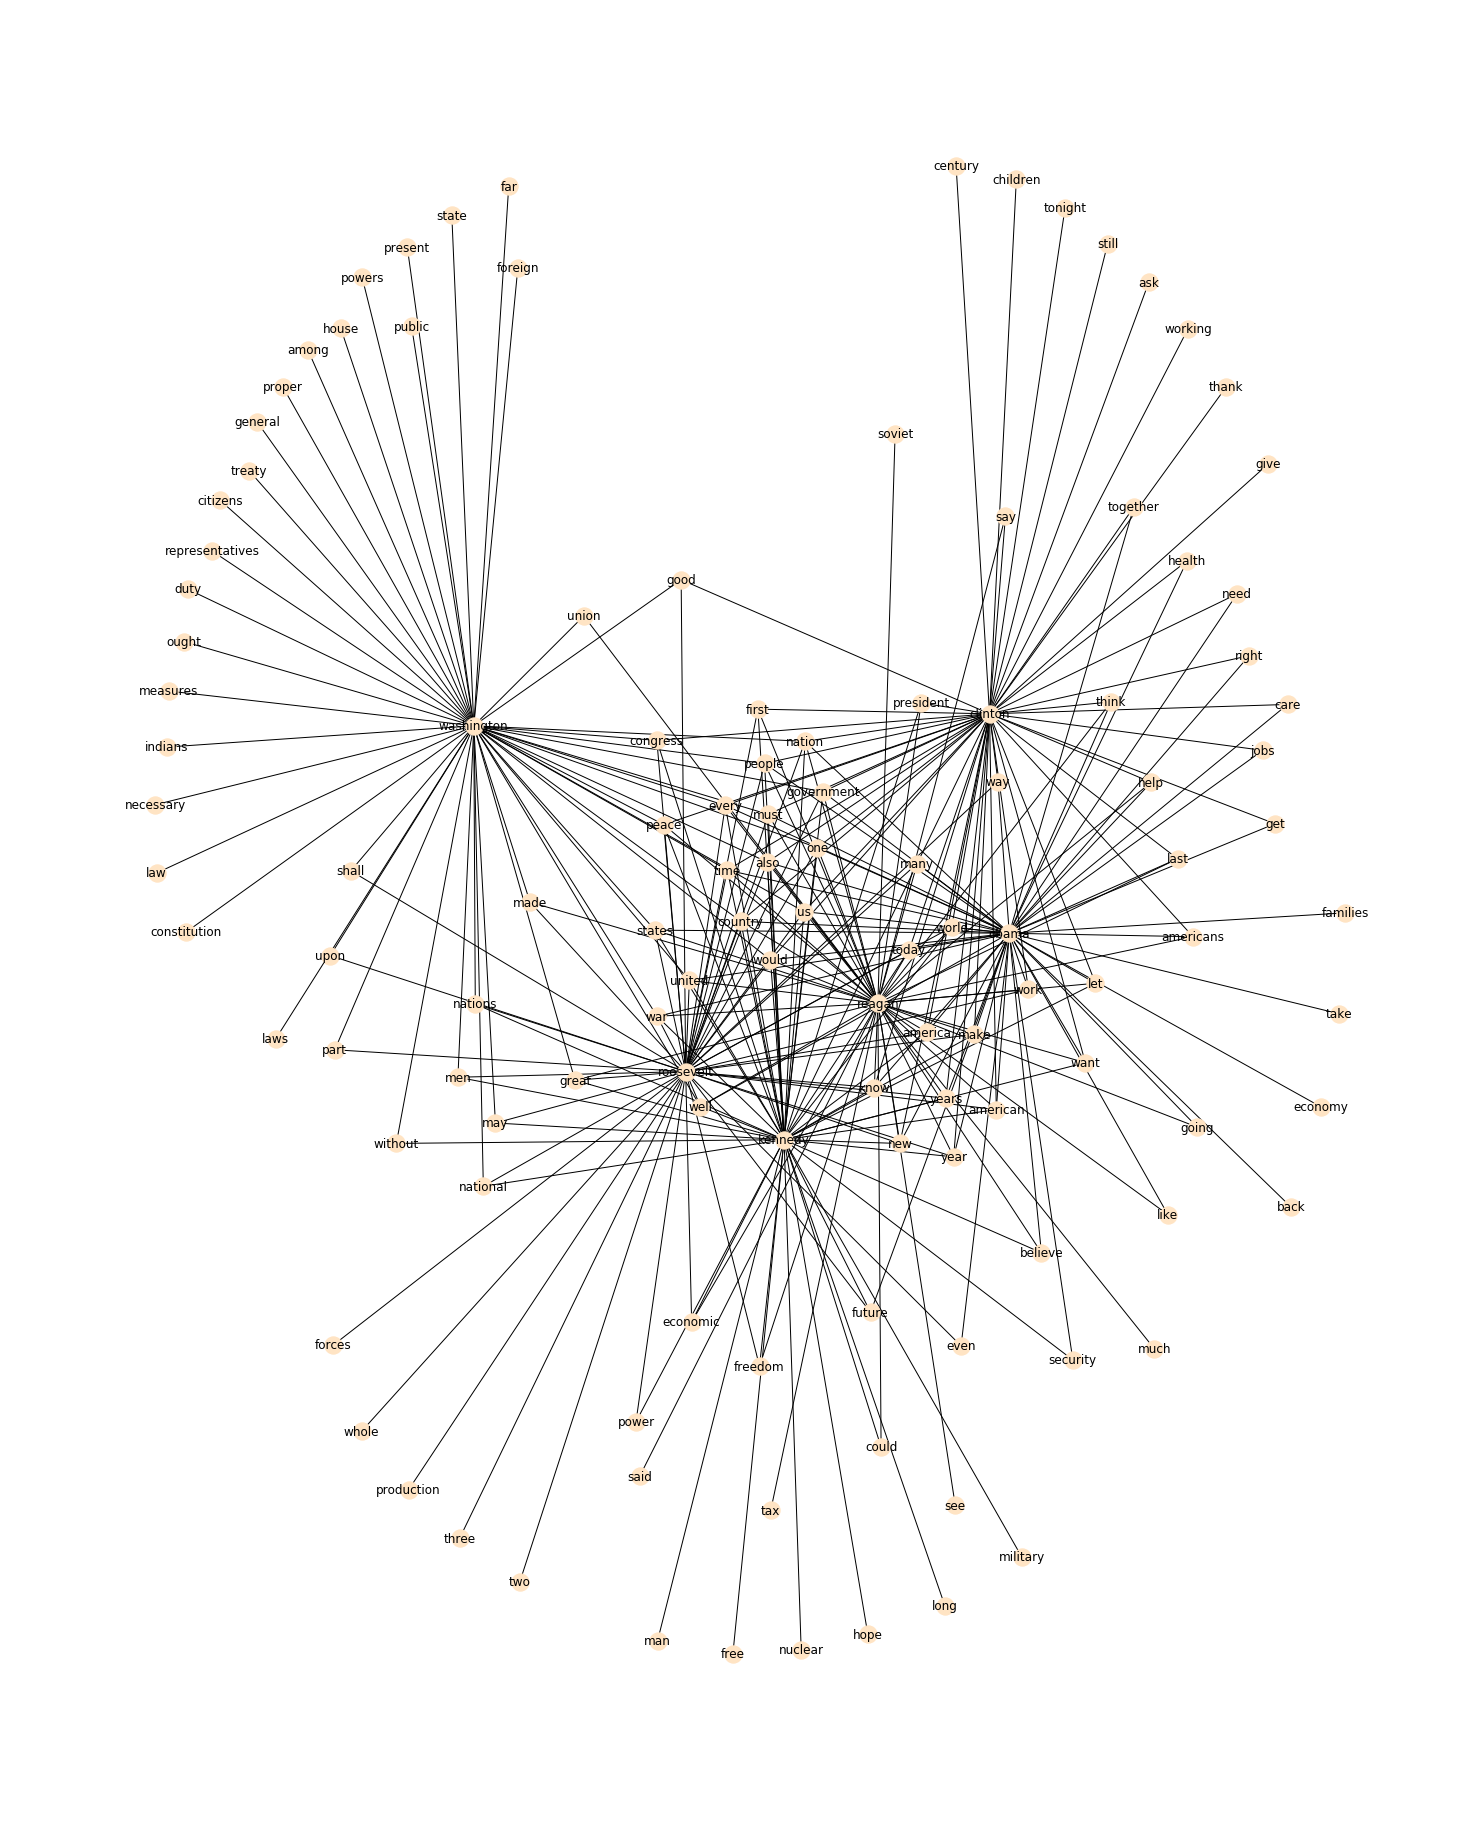

In [11]:
plt.rcParams['figure.figsize'] = (20, 25)
nx.draw(G, node_color='bisque', with_labels=True)

In [12]:
view_pyvis = True

In [13]:
if view_pyvis:
    N = Network(height='1000px',
                    width='1000px',
                    bgcolor='#222222', 
                    font_color='white', 
                    notebook=True)
    N.barnes_hut()
    for n in G.nodes():
        N.add_node(n)
    for e in G.edges():
        N.add_edge(e[0], e[1])
        
N.show('network_1.html')    

### Islands

we need to breakdown the network into islands.  The island method uses a system of weights to drop off the lowest values. It allows us to take a graph, like the one above, and systematically "raise the water level" (apply weights) to leave only the strongest amount of activity; leaving them to become their own components.  

This method generally produces multiple levels to raise the weight to.  We may not need all the islands to show the commonality in the data.  

In [14]:
token = [node for node in G.nodes() if node in speakers.tokens.unique()]
W = bipartite.weighted_projected_graph(G, token)
CC = list(nx.connected_component_subgraphs(W))[0]
islands=island_method(CC)

In [15]:
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    print(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1]))))

1 67 1
2 48 1
3 32 1
4 26 1
5 11 1


In [16]:
# Breaking the islands into seperate dataframes
lvl1 = islands[0][1]
lvl2 = islands[1][1]
lvl3 = islands[2][1]
lvl4 = islands[3][1]
lvl5 = islands[4][1]
#lvl6 = islands[5][1]
#lvl7 = islands[6][1]

In [17]:
C = Network(height='1000px',
            width='1000px',
            bgcolor='#222222', 
            font_color='white', 
            notebook=True)

C.barnes_hut()
for n in lvl1.nodes():
    C.add_node(n)
for e in lvl1.edges():
    C.add_edge(e[0], e[1])
C.show('island1.html')

At the first level, we lose a bit of the pure starburst pattern and start to see some offshoots.  We can start to get an understanding of the general word usage.  Further levels should break this down further; next we move to level 3.

In [18]:
C = Network(height='1000px',
            width='1000px',
            bgcolor='#222222', 
            font_color='white', 
            notebook=True)

C.barnes_hut()
for n in lvl3.nodes():
    C.add_node(n)
for e in lvl3.edges():
    C.add_edge(e[0], e[1])
C.show('island3.html')

At the 3rd level, we can really start taking stock of the strong word connections.  Its hard or impossible to derive context from network graphs but there are some things that are telling.  Examples like 'CONGRESS' is connected to "government, people, country, us, every, time, one, nation, peace..." but it's not connected at this level to other words in unexpected ways "America, American, work, want, great".

Next, we jump to the last island.

In [19]:
C = Network(height='1000px',
            width='1000px',
            bgcolor='#222222', 
            font_color='white', 
            notebook=True)

C.barnes_hut()
for n in lvl5.nodes():
    C.add_node(n)
for e in lvl5.edges():
    C.add_edge(e[0], e[1])
C.show('island5.html')

These are the most connected words in the network.  Reading the words, we do get a sense of the job of the president, leading government by keeping us together.  

Now, that we have an understanding of the words used, can we build a model to accurately predict speaker of each of these speeches? 

## Predictions

We are going to utilize two different methods and figure out which one produces a more accurate model. 

### Method 1 - Naive Bayes Classifier with Word Features
We will split the data by speaker into 1000 word chunks and run them through NLTK's frequency distribution function to gain the top 200 words.  Taking a random set from the word chunks, we will split them into a Train/Test to run the Naive Bayes Classifier.  

### Method 2 - Logistic Regression
We will use a count vectorizer and TFIDF transfomer to numerically encode the text and surface the most important words in each message. The classifiers will then learn which aspects of the processed data will be most predictive. We will use a Train/Test split of 70/30.

#### Method 1

We are going to start with the latest President listed as one of the great orators, Barack Obama, and confirm we can build a model to differentiate with the our first President, George Washington. 

##### Obama and Washington

In [20]:
len(obama)/1000

98.413

In [21]:
# using the length above, we can split the dataset into 1000 word chunks and set a label for the words.
obama1=[]
for i in range(98):
    obama1.append([obama[i*1000:(i+1)*1000], 'ob'])

In [22]:
len(washington)/1000

14.751

In [23]:
washington1=[]
for i in range(14):
    washington1.append([washington[i*1000:(i+1)*1000], 'wa'])

In [24]:
# combining the starting data
wo = obama+washington

In [25]:
# combining the modified data
speeches = washington1+obama1

In [26]:
#generating the word features
all_words = nltk.FreqDist(w.lower() for w in wo)
word_features = list(all_words)[:200]

In [27]:
# shuffling the modified groups.
random.shuffle(speeches)

In [28]:
# creating the feature sets.  The Length is to ensure we don't have a value of zero.
featuresets = [(document_features(d), c) for (d,c) in speeches]
len(featuresets)

112

In [29]:
# Setting up the Train/Test set and running the classifier
train_set, test_set = featuresets[50:], featuresets[:50]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [30]:
print(nltk.classify.accuracy(classifier, test_set))

1.0


100% accuracy may seem incorrect or overfit, however, in this case it is not.  The Naive Bayes Classifier can accurately determine the difference in Obama and Washington. As we have seen in the network graphs above, there is a big enough difference between the two speakers to feel comfortable with the accuracy being so high. The model only has two choices, not much work for it.

As we add other speakers, the accuracy will drop.  The question will remain, will it drop too much to be of use.   

##### Roosevelt

Next, we will start to add the remaining Presidents.  Our goal is by the end of adding all 5 top modern orators, we still have an acceptable accuracy. We start with Roosevelt, as he is the first of the "modern era" speakers defined in the article.  

In [31]:
#len(roosevelt)/1000

In [32]:
roosevelt1=[]
for i in range(63):
    roosevelt1.append([roosevelt[i*1000:(i+1)*1000], 'ro'])

In [33]:
rwo = obama+washington+roosevelt
speeches = washington1+obama1+roosevelt1
all_words = nltk.FreqDist(w.lower() for w in rwo)
word_features = list(all_words)[:200]
random.shuffle(speeches)
featuresets = [(document_features(d), c) for (d,c) in speeches]
#len(featuresets)

In [34]:
train_set, test_set = featuresets[50:], featuresets[:50]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.98


98% is really good.  We dropped out of the pure accuracy and into acceptable levels.  

Kennedy

In [35]:
#len(kennedy)/1000

In [36]:
kennedy1=[]
for i in range(58):
    kennedy1.append([kennedy[i*1000:(i+1)*1000], 'ke'])

rwok = obama+washington+roosevelt+kennedy
speeches = washington1+obama1+roosevelt1+kennedy1

all_words = nltk.FreqDist(w.lower() for w in rwok)
word_features = list(all_words)[:200]

random.shuffle(speeches)
featuresets = [(document_features(d), c) for (d,c) in speeches]
#len(featuresets)

In [37]:
train_set, test_set = featuresets[50:], featuresets[:50]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.96


96%! We are still on track.  Our next two speakers, however, are from very near in time to each other. There is only a 4 year gap between them taking office.  

Clinton

In [38]:
#len(clinton)/1000

In [39]:
clinton1=[]
for i in range(66):
    clinton1.append([clinton[i*1000:(i+1)*1000], 'cl'])
    
rwokc = obama+washington+roosevelt+kennedy+clinton
speeches = washington1+obama1+roosevelt1+kennedy1+clinton1

all_words = nltk.FreqDist(w.lower() for w in rwokc)
word_features = list(all_words)[:200]

random.shuffle(speeches)
featuresets = [(document_features(d), c) for (d,c) in speeches]
#len(featuresets)

In [40]:
train_set, test_set = featuresets[50:], featuresets[:50]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.76


As we expected, there is a large drop from the previous models.  It's still in an acceptable range.  

Reagan

In [41]:
#len(reagan)/1000

In [42]:
reagan1=[]
for i in range(99):
    reagan1.append([reagan[i*1000:(i+1)*1000], 're'])
    
rwokcr = obama+washington+roosevelt+kennedy+clinton+reagan
speeches = washington1+obama1+roosevelt1+kennedy1+clinton1+reagan1

all_words = nltk.FreqDist(w.lower() for w in rwokcr)
word_features = list(all_words)[:200]

random.shuffle(speeches)
featuresets = [(document_features(d), c) for (d,c) in speeches]
len(featuresets)

train_set, test_set = featuresets[50:], featuresets[:50]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.76


76% with 6 modern speakers while not applying weights during the tokenization method is still a good result.  While this method does allow us to continue with other features of the NLTK package (Context, etc..) those are out of the scope of this paper.  We could improve the scores by running a second round of testing, letting the model see more of the data.

We do have a clear understanding of what we can do next.  We can adjust the raw frequencies of word occurrence and scale down the impact of high frequency words and are empirically less informative as a feature than those which present in a small fraction of the training set.  Basically, can we take the words from Island 1 and make any which are present in Island 3 and 5 have less weight?  Enter Logistic Regression with TFIDF.   

#### Method 2 - Logistic Regression

We will now look at TFIDF score for each speech and use the president label to train other classifiers. We will see if we can improve upon the results above.  Logistic regression is very helpful in performing a spam/ham classifer, it was again very helpful in comparsion to several other model types.

In [43]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in nopunc.split() 
            if word.lower() 
            not in stopwords.words('english')]

In [44]:
all_speechs = all_speechs[all_speechs.President.isin(
    ["George Washington", 'Franklin D. Roosevelt',
     "Barack Obama",'John F. Kennedy',
     'Bill Clinton','Ronald Reagan'])]

In [45]:
X_train, X_test, y_train, y_test = \
    train_test_split(all_speechs.Transcript, 
                     all_speechs.President, 
                     test_size=0.30,
                     random_state=random.seed(42),
                     stratify=all_speechs.President)

In [46]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', LogisticRegression(multi_class='multinomial',
                                     solver="lbfgs"))  
])

In [47]:
pipeline.fit(X_train,y_train)
predictions = pipeline.predict(X_test)

In [48]:
print(classification_report(predictions,y_test))

                       precision    recall  f1-score   support

         Barack Obama       1.00      0.94      0.97        16
         Bill Clinton       0.67      1.00      0.80         8
Franklin D. Roosevelt       1.00      1.00      1.00        15
    George Washington       1.00      1.00      1.00         6
      John F. Kennedy       0.92      1.00      0.96        12
        Ronald Reagan       1.00      0.82      0.90        22

             accuracy                           0.94        79
            macro avg       0.93      0.96      0.94        79
         weighted avg       0.95      0.94      0.94        79



In [49]:
print(confusion_matrix(predictions,y_test))

[[15  1  0  0  0  0]
 [ 0  8  0  0  0  0]
 [ 0  0 15  0  0  0]
 [ 0  0  0  6  0  0]
 [ 0  0  0  0 12  0]
 [ 0  3  0  0  1 18]]


Here we see that a multi-class logistic regression model performs very well with 93% accuracy and 96% recall. The model had a hard time separating Obama and Clinton.

### Final Thoughts

To model or predict speeches, the TFIDF method is the superior method.  It has a much better accuracy.  

This leaves us with an interesting theory.  The most important aspect of a speech is not the common words everyone uses but the other words used to promote or enhance those common words.  While each speaker has their individual speech print, it's the less frequent aspect of the speech which holds more weight.

But I think we all know that already (cough #45)...

[Video Link](https://youtu.be/HVeM77C6G-c)